In [1]:
import pandas as pd
import numpy as np
from collections import Counter
from time import time
# Set some Pandas options
pd.set_option('display.notebook_repr_html', True)
pd.set_option('display.max_columns', 20)
pd.set_option('display.max_rows', 25)
import matplotlib.pyplot as plt
get_ipython().magic(u'matplotlib inline') 
get_ipython().magic(u"config InlineBackend.figure_format='retina'")
import seaborn as sns
# Library's to apply balance technic's
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
# Import the necessary module's
from scipy.stats import chi2
from sklearn.preprocessing import MinMaxScaler,binarize
from sklearn.feature_selection import SelectKBest,mutual_info_classif,chi2,RFE,RFECV,SelectFromModel
from sklearn.model_selection import train_test_split,GridSearchCV,cross_validate
from sklearn.svm import LinearSVC,SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier,RandomForestClassifier
from sklearn.metrics import accuracy_score,roc_auc_score,precision_score,recall_score,f1_score,average_precision_score
from sklearn.metrics import roc_curve,classification_report,confusion_matrix,make_scorer
# Only for final delivery
import warnings
warnings.filterwarnings('ignore')

#### Plot functions

* Funciones personalizadas creadas para visualizar los datos

In [2]:
def plot_pie(y):
    target_stats = Counter(y)
    labels = list(target_stats.keys())
    sizes = list(target_stats.values())
    explode = tuple([0.1] * len(target_stats))

    fig, ax = plt.subplots()
    ax.pie(sizes, explode=explode, labels=labels, shadow=True,
           autopct='%1.1f%%')
    ax.axis('equal')

### Caracterización general del dataset

* Hay 2230 registros de canciones de todo tipo y 70 de reggaeton. Las variables para ambos dataset son similares a excpeción de *time_signature* que solo está presente en las canciones de todo tipo.


* Las variables *key* y *mode* son enteros que representan categorías, mientras que *duration* es una variable que representa el tiempo en milisegundo. El resto de las variables corresponden a distintos score numéricos que representan características de los track como popularidad, qué tan apto es para el baile, qué tan vocal o instrumental es, etc.


* Podemos ver que la cantidad de NA's es 0 para los track de reggaeton y muy baja para los track de otro tipo, en donde ninguna variable tiene más de 8 valores NAs, correspondientes a un 0.36% de los datos. 


* **Dada la baja proporción de NAs y que estos corresponden al dataset que contiene la clase mayoritaria no se harán imputaciones y se trabajará solo con los datos completos.**

In [3]:
df_todotipo=pd.read_csv('data_todotipo.csv',encoding='utf-8',sep=',')
del df_todotipo['Unnamed: 0']
df_todotipo=df_todotipo.dropna(how='any',axis=0).copy()
df_reggaeton=pd.read_csv('data_reggaeton.csv',encoding='utf-8',sep=',')
del df_reggaeton['Unnamed: 0']

#### Union de los datasets

* Para analizar el resto de las variables vamos a trabajar con el dataset ya unido, de tal forma que podamos comparar la variable cuando es reggaeton y cuando no de forma más simple y rápida.


* Para ello definiremos una variable *reggaeton* como 1 cuando sea un track de reggaeton y con valor 0 en cualquier otro caso. Posteriormente, unificaremos los tipos de datos de ambos dataset y finalmente haremos la unión.

In [4]:
del df_todotipo['time_signature']
df_reggaeton['reggaeton']=1
df_todotipo['reggaeton']=0
df_reggaeton['popularity']=df_reggaeton.popularity.astype('float64')
df_reggaeton['duration']=df_reggaeton.duration.astype('float64')
df=pd.concat([df_reggaeton,df_todotipo]).copy()
df.loc[:,"key_code"] = df.key.astype('category')
df.loc[:,"mode_code"] = df['mode'].astype('category')
del df['key']
del df['mode']
del df['id_new']
df.loc[:,"reggaeton"] = df.reggaeton.astype('category')
df.loc[:,'loudness_scale']=MinMaxScaler().fit_transform(df[['loudness']])
df.loc[:,'tempo_scale']=MinMaxScaler().fit_transform(df[['tempo']])
del df['loudness']
del df['tempo']

##### Separación de features y target

* Separamos las variables del target, dejando los valores de los features en la variable *X* y los del target en el *y*

Información del dataset:
 las clases del target son: Counter({0: 2222, 1: 70})


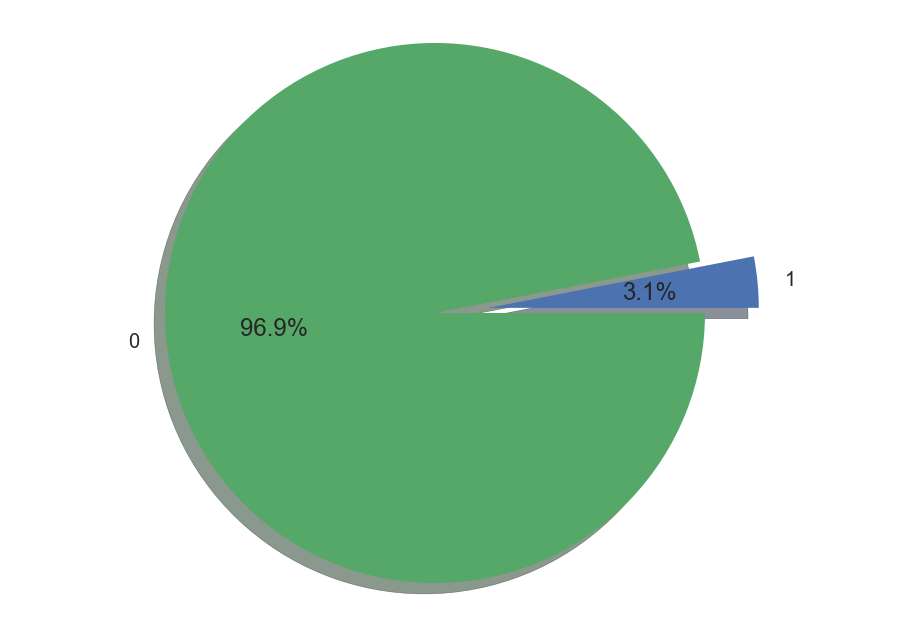

In [5]:
X=df.loc[:, df.columns != 'reggaeton']
y=df.reggaeton.ravel()
print('Información del dataset:'
      '\n las clases del target son: {}'.format(Counter(y)))
plot_pie(y)

### Balance de clases

* Dado que la cantidad de clases positivas es extremadamente baja, usaremos la técnica de balance de clases Smote, la cual genera clases sintéticas en *la mitad de camino* a partir de los vecinos más cercanos de cada punto de la clase minoritaria, hasta equiparar a la mayoritaria

** Fuente: **
*<https://beckernick.github.io/oversampling-modeling/>*

Información del dataset aplicando el algoritmo Smote:
 y: Counter({1: 2222, 0: 2222})


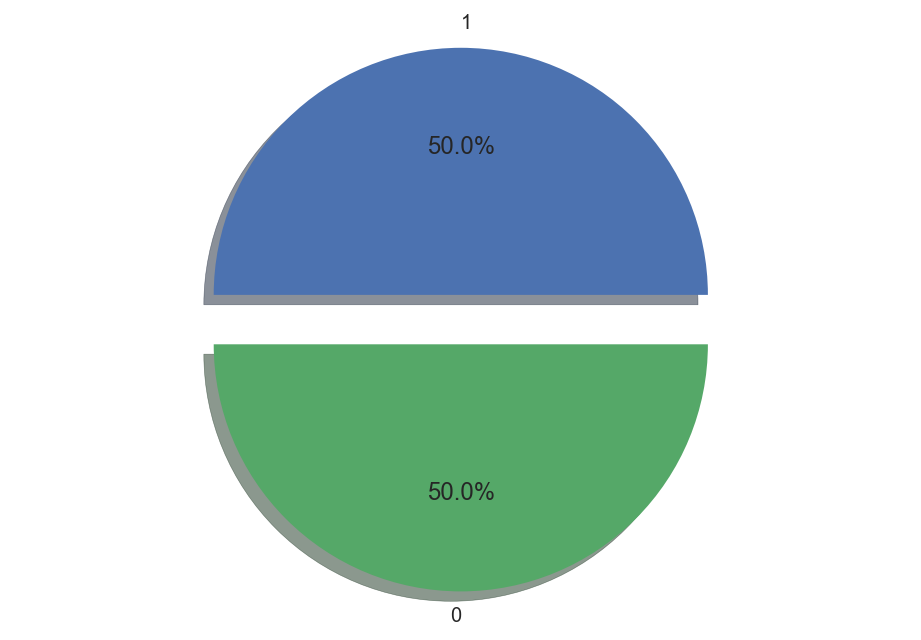

In [6]:
sm = SMOTE(random_state=0,n_jobs=-1,ratio='minority')
X_res, y_res = sm.fit_sample(X, y)
print('Información del dataset aplicando el algoritmo Smote:'
      '\n y: {}'.format(Counter(y_res)))
plot_pie(y_res)

#### Estructura del dataset

* Para entrenar el modelo vamos a dividir el dataset de forma aleatoria en un 70% para entrenar y un 30% para testear, de tal forma que las proporciones de las clases se mantengan constantes

* Para atacar el problema de balance de clases,usaremos la técnica SMOTE, que genera variables sintéticas hasta generar la misma cantidad de casos de la clase mayoritaría para la que era minoritaria. En este caso, no usaremos RandomUnderSample dado que la clase minoritaria representa apenas un 3% de los datos

* Se tendrá especial cuidado en usar la técnica de balance de clases **solo para los datos de entrenamiento**, ya que los datos de test siempre deben estar sin manipulación de este tipo

Información del dataset:
 las clases del target son: Counter({0: 1565, 1: 39})


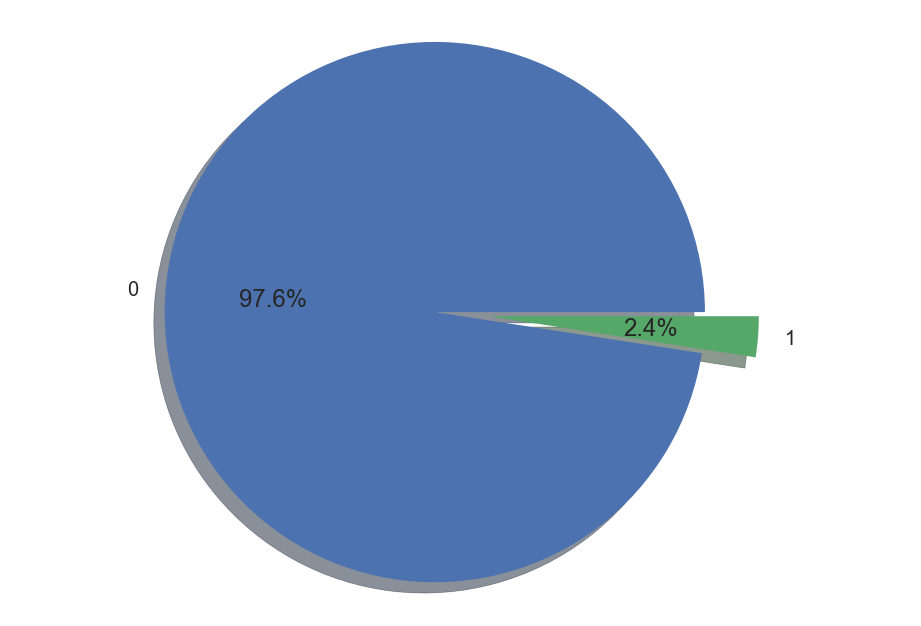

In [7]:
# Create training and test sets
X_train, X_test, y_train, y_test = train_test_split(X,y,random_state=0,test_size=0.3)
print('Información del dataset:'
      '\n las clases del target son: {}'.format(Counter(y_train)))
plot_pie(y_train)

Información del dataset aplicando el algoritmo Smote:
 y: Counter({0: 1565, 1: 1565})


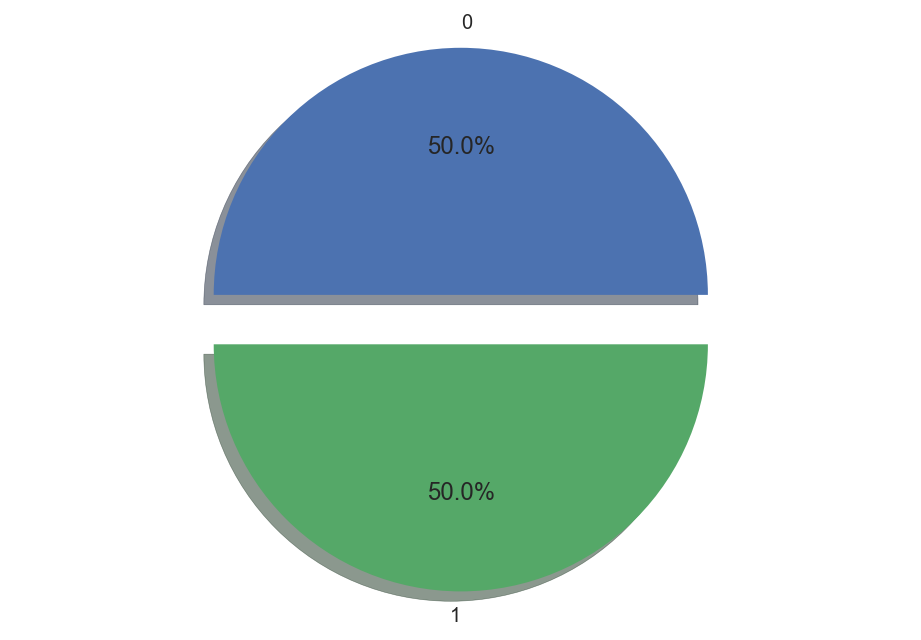

In [8]:
sm = SMOTE(random_state=0,n_jobs=-1)
X_train_res, y_train_res = sm.fit_sample(X_train, y_train)
print('Información del dataset aplicando el algoritmo Smote:'
      '\n y: {}'.format(Counter(y_train_res)))
plot_pie(y_train_res)

### Selección de variables

* Basados en el análisis estadístico, en los resultados de la métrica Mutual Information, el orden de importancia por coeficiente de SVClineal y por los resultados de aplicar Recursive feature engineer con los algoritmos Random Forest, Gradient Boosting y Regresión logística se decide eliminar 5 variables que eran candidatas:
    * *duration*
    * *liveness*
    * *loudness*
    * *key_code*
    * *instrumentalness*
    
** Referencias: **

*<https://www.svds.com/learning-imbalanced-classes/>*

*<http://www.wildcardconsulting.dk/useful-information/never-do-this-mistake-when-using-feature-selection/>*

*<https://github.com/iair/hrAnalytics/blob/master/Anal%C3%ADtica%20de%20recursos%20humanos-%20Fuga%20de%20talentos%20-%20Parte%201.ipynb>*

In [9]:
def variable_selection(X,y):
    
    # Generamos la métrica de mutual information de los features con respecto al Score 
    mi = mutual_info_classif(X,y,random_state=0,discrete_features='auto')
    # Creamos el dataframe con los resultados
    raw_data={'features':X.columns.values,'m-score':mi,'m-weight':mi/np.max(mi)}
    features_mi=pd.DataFrame(raw_data,columns=['features','m-score','m-weight'])
    features_mi=features_mi.sort_values(by='m-weight',ascending=False)
    
    # Generamos el el clasificador con Random Forest
    clf = RandomForestClassifier(
        bootstrap=True, criterion='gini',max_features='sqrt',min_samples_split=23,
        n_estimators=300,random_state=0,warm_start=True,n_jobs=-1, min_samples_leaf =23)
    # Aplicamos el Recursive feature engineer utilizando el modelo de Random Forest
    rfe_rf = RFE(clf, n_features_to_select=1)
    fit_rf = rfe_rf.fit(X, y)
    # Creamos el dataframe con los resultados uniéndolo a los resultados anteriores
    raw_data={'features':X.columns.values,'ranking_ffe_rf':fit_rf.ranking_}
    features_ffe_rf=pd.DataFrame(
        raw_data,columns=['features','ranking_ffe_rf']).sort_values(by='ranking_ffe_rf',ascending=True)
    selected_features=pd.merge(left=features_mi,right=features_ffe_rf, how='left', on='features', 
                               sort=False,suffixes=('_mi', '_ffe_rf'), copy=True, indicator=False)
    
    # Generamos el el clasificador con Regresión logística
    model = LogisticRegression(random_state=0,warm_start=True)
    # Aplicamos el Recursive feature engineer utilizando el modelo de Regresión Logística
    rfe_lr = RFE(model, n_features_to_select=1)
    fit_rl = rfe_lr.fit(X, y)
    # Creamos el dataframe con los resultados uniéndolo a los resultados anteriores
    raw_data={'features':X.columns.values,'ranking_ffe_rl':fit_rl.ranking_}
    features_ffe_rl=pd.DataFrame(
        raw_data,columns=['features','ranking_ffe_rl']).sort_values(by='ranking_ffe_rl',ascending=True)
    selected_features=pd.merge(left=selected_features,right=features_ffe_rl, how='left', on='features', left_on=None, 
                               sort=False,suffixes=('', '_ffe_rl'), copy=True, 
                               indicator=False)
    
    # Generamos el el clasificador con Gradient Boosting
    model = GradientBoostingClassifier(
        random_state=0,max_features='sqrt',subsample=0.8,
        n_estimators=300,min_samples_split = 20,warm_start=True,presort=True)
    # Aplicamos el Recursive feature engineer utilizando el modelo de Gradient Boosting
    rfe_gb = RFE(model, n_features_to_select=1)
    fit_gb = rfe_gb.fit(X=X, y=y)
    # Creamos el dataframe con los resultados uniéndolo a los resultados anteriores
    raw_data={'features':X.columns.values,'ranking_ffe_gb':fit_gb.ranking_}
    features_ffe_gb=pd.DataFrame(
        raw_data,columns=['features','ranking_ffe_gb']).sort_values(by='ranking_ffe_gb',ascending=True)
    selected_features=pd.merge(left=selected_features,right=features_ffe_gb, how='left', on='features',
                               suffixes=('', '_ffe_gb'), copy=True, indicator=False)
    
    # Generamos el el clasificador con Linear SVC
    lsvc = LinearSVC(C=1, penalty="l1", random_state=0,dual=False,loss='squared_hinge').fit(X, y)
    # Aplicamos el Recursive feature engineer utilizando el modelo de Linear SVC
    model = SelectFromModel(lsvc, prefit=True)
    X_new = model.transform(X)
    # Creamos el dataframe con los resultados uniéndolo a los resultados anteriores
    raw_data={'features':X.columns.values,'coef_svc':np.abs(lsvc.coef_[0])}
    features_svc=pd.DataFrame(raw_data,columns=['features','coef_svc']).sort_values(by='coef_svc',ascending=False)
    features_svc['ranking_svc']=range(1,len(lsvc.coef_[0])+1)
    selected_features=pd.merge(left=selected_features,right=features_svc, how='left', on='features',
                               sort=False,suffixes=('', '_svc_lineal'), copy=True, indicator=False)
    
    return selected_features

CPU times: user 25.4 s, sys: 2.95 s, total: 28.3 s
Wall time: 28.3 s


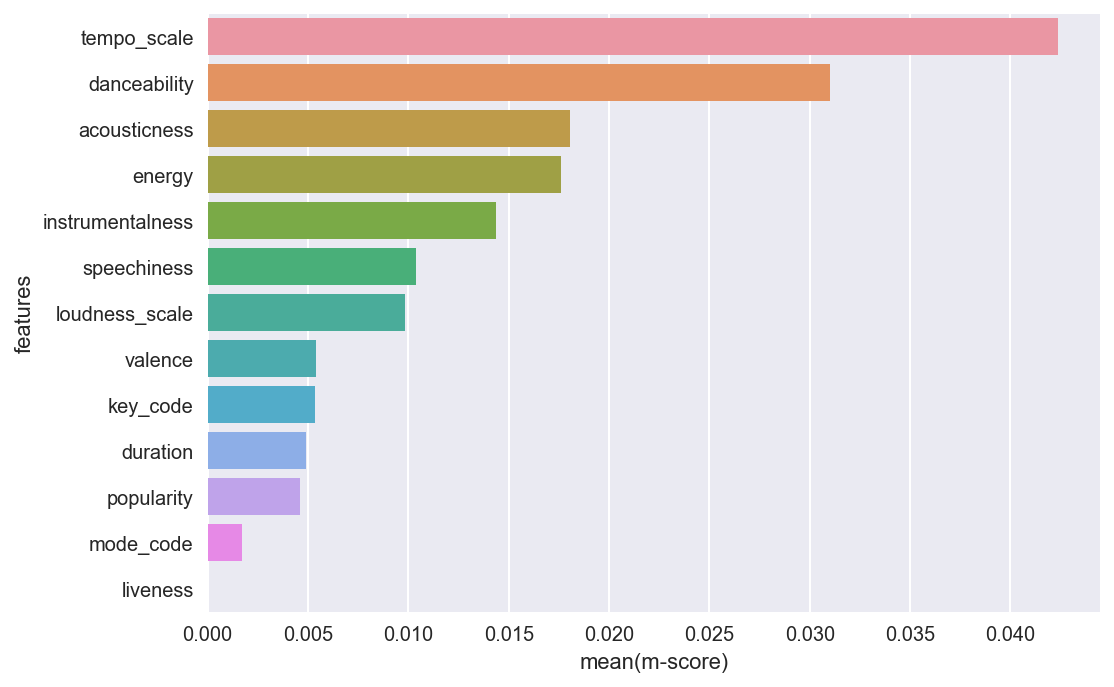

In [10]:
%%time
selected_features=variable_selection(X_train,y_train)
sns.barplot(x='m-score', y='features', data=selected_features);

In [11]:
selected_features.sort_values(by='ranking_ffe_gb',ascending=True)

,features,m-score,m-weight,ranking_ffe_rf,ranking_ffe_rl,ranking_ffe_gb,coef_svc,ranking_svc
0,tempo_scale,0.042365,1.000000,2,2,1,9.176125e-01,3
1,danceability,0.031020,0.732212,1,1,2,1.415367e+00,2
6,loudness_scale,0.009853,0.232579,6,6,3,3.144937e-02,9
5,speechiness,0.010370,0.244780,4,5,4,1.418962e+00,1
9,duration,0.004912,0.115937,10,13,5,5.259028e-07,13
3,energy,0.017582,0.415019,5,7,6,5.760765e-01,4
12,liveness,0.000000,0.000000,9,8,7,1.176332e-01,7
2,acousticness,0.018059,0.426270,7,4,8,2.777170e-01,6
7,valence,0.005377,0.126917,8,10,9,5.460237e-02,8
4,instrumentalness,0.014365,0.339070,3,3,10,5.659826e-01,5


In [12]:
%%time
# Extracción de variables con Mutual Information
mi = mutual_info_classif(X_train_res,y_train_res,random_state=0,discrete_features='auto')
# Extracción de variables con RFE y RF
clf = RandomForestClassifier(
    bootstrap=True, criterion='gini',max_features='sqrt',min_samples_split=30,
    n_estimators=500,random_state=0,warm_start=True,n_jobs=-1, min_samples_leaf =30)
#class_weight='balanced'
rfe_rf = RFE(clf, n_features_to_select=1)
fit_rf = rfe_rf.fit(X_train_res,y_train_res)
# Extracción de variables con RFE y LR
model = LogisticRegression(random_state=0,warm_start=True)
rfe_lr = RFE(model, n_features_to_select=1)
fit_rl = rfe_lr.fit(X_train_res,y_train_res)
# Extracción de variables con RFE y GB
model = GradientBoostingClassifier(
    random_state=0,max_features='sqrt',subsample=0.8,n_estimators=300,min_samples_split = 30,
    warm_start=True,presort=False)
rfe_gb = RFE(model, n_features_to_select=1)
fit_gb = rfe_gb.fit(X_train_res,y_train_res)
# Extracción de variables con 
lsvc = LinearSVC(random_state=0).fit(X_train_res,y_train_res)
model = SelectFromModel(lsvc, prefit=True)
X_new = model.transform(X_test)

CPU times: user 1min 5s, sys: 3.73 s, total: 1min 9s
Wall time: 57.5 s


In [13]:
# Creamos el dataframe con los resultados
raw_data={'features':X.columns.values,'m-score':mi,'m-weight':mi/np.max(mi)}
features_mi=pd.DataFrame(raw_data,columns=['features','m-score','m-weight'])
features_mi=features_mi.sort_values(by='m-weight',ascending=False)
raw_data={'features':X.columns.values,'ranking_ffe_rf':fit_rf.ranking_}
features_ffe_rf=pd.DataFrame(
    raw_data,columns=['features','ranking_ffe_rf']).sort_values(by='ranking_ffe_rf',ascending=True)
selected_features=pd.merge(left=features_mi,right=features_ffe_rf, how='left', on='features', 
                           sort=False,suffixes=('_mi', '_ffe_rf'), copy=True, indicator=False)
selected_features.sort_values(by='ranking_ffe_rf',ascending=True)
raw_data={'features':X.columns.values,'ranking_ffe_rl':fit_rl.ranking_}
features_ffe_rl=pd.DataFrame(
    raw_data,columns=['features','ranking_ffe_rl']).sort_values(by='ranking_ffe_rl',ascending=True)
selected_features=pd.merge(left=selected_features,right=features_ffe_rl, how='left', on='features', left_on=None, 
                           sort=False,suffixes=('', '_ffe_rl'), copy=True, 
                           indicator=False)
selected_features.sort_values(by='ranking_ffe_rl',ascending=True)
raw_data={'features':X.columns.values,'ranking_ffe_gb':fit_gb.ranking_}
features_ffe_gb=pd.DataFrame(
    raw_data,columns=['features','ranking_ffe_gb']).sort_values(by='ranking_ffe_gb',ascending=True)
selected_features=pd.merge(left=selected_features,right=features_ffe_gb, how='left', on='features',
                           suffixes=('', '_ffe_gb'), copy=True, indicator=False)
selected_features.sort_values(by='ranking_ffe_gb',ascending=True)
raw_data={'features':X.columns.values,'coef_svc':np.abs(lsvc.coef_[0])}
features_svc=pd.DataFrame(raw_data,columns=['features','coef_svc']).sort_values(by='coef_svc',ascending=False)
features_svc['ranking_svc']=range(1,len(lsvc.coef_[0])+1)
selected_features=pd.merge(left=selected_features,right=features_svc, how='left', on='features',
                           sort=False,suffixes=('', '_svc_lineal'), copy=True, indicator=False)
selected_features.sort_values(by='ranking_ffe_gb',ascending=True)

,features,m-score,m-weight,ranking_ffe_rf,ranking_ffe_rl,ranking_ffe_gb,coef_svc,ranking_svc
3,energy,0.308517,0.581904,4,6,1,5.075616e-06,6
9,duration,0.187185,0.353056,12,1,2,3.680948e-06,8
2,danceability,0.320262,0.604056,1,5,3,2.731263e-06,9
5,tempo_scale,0.259231,0.488944,5,8,4,4.956511e-06,7
10,liveness,0.184836,0.348625,9,13,5,1.328921e-07,13
6,speechiness,0.242117,0.456665,3,10,6,8.530565e-07,12
4,acousticness,0.291641,0.550073,2,3,7,1.333737e-05,4
11,loudness_scale,0.183135,0.345417,7,11,8,1.424752e-06,10
8,valence,0.196143,0.369952,6,7,9,1.146069e-06,11
1,key_code,0.511872,0.965457,13,9,10,3.588767e-05,2


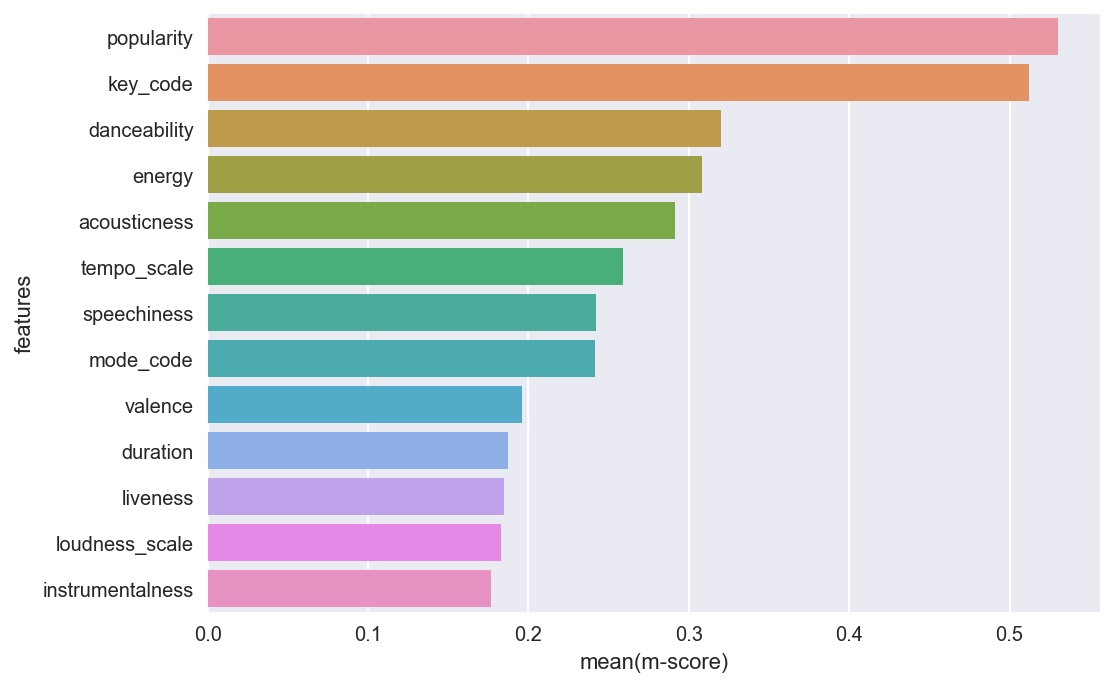

In [14]:
sns.barplot(x='m-score', y='features', data=features_mi);

In [15]:
del X['key_code']
del X['instrumentalness']
del X['duration']
del X['loudness_scale']
del X['popularity']
del X['liveness']
del X['mode_code']

### Entrenamiento

* Se utilizaran 5 modelos para entrenar utilizando validación cruzada con k=10 y se evaluaran todas las métricas de clasificación y se escogerá aquel modelo que obtenga el mejor balance de ellas. Sin embargo, las principales serán el Accuracy y el F1


* Si bien se usaran modelos de Support vector, estos son más que nada para ser usados como benchmark. En general, bajo resultados similares, se favorecerán los modelos con base en árboles o regresiones por su fácil interpretabilidad y aplicabilidad en términos de negocio


* Para los algoritmos de Random Forest y Gradient Boosting se restringe la mínima cantiad de datos para que los árboles hagan split, para que se cree un nodo final y la máxima cantidad de features. Todo esto con el objetivo de disminuir el riesgo de sobre-ajuste. Al GB también se le indica que tome muestras del 80% para iterar, de tal forma que el algoritmo no se aprenda los datos *de memoria* en la medida que va haciendo la convergencia


* Para los algoritmos de SVC y SVC lineal el parámetro C se deja en 0.1

Información del dataset:
 las clases del target son: Counter({0: 1565, 1: 39})


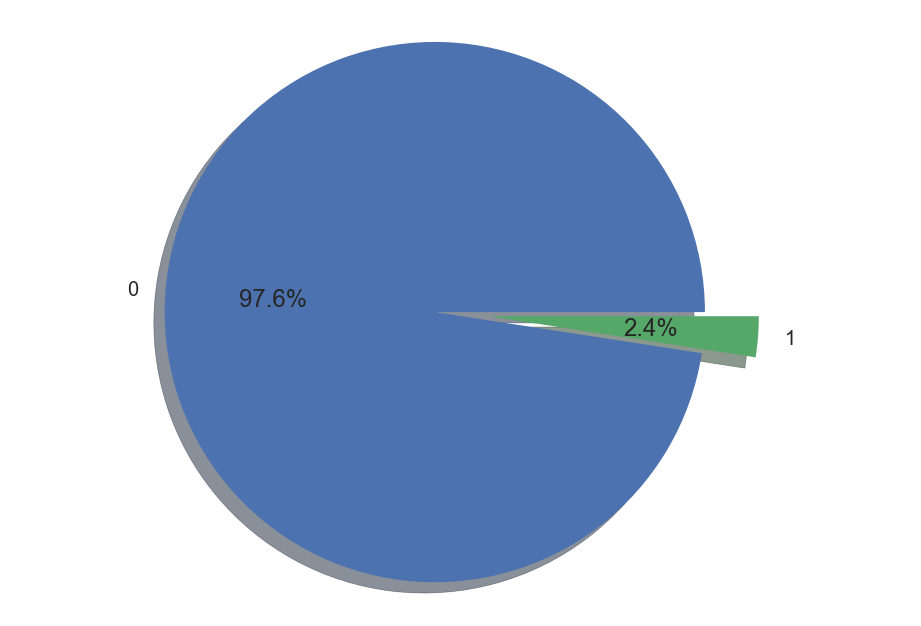

In [16]:
# Create training and test sets
X_train, X_test, y_train, y_test = train_test_split(X,y,random_state=0,test_size=0.3)
print('Información del dataset:'
      '\n las clases del target son: {}'.format(Counter(y_train)))
plot_pie(y_train)

Información del dataset aplicando el algoritmo Smote:
 y: Counter({0: 1565, 1: 1565})


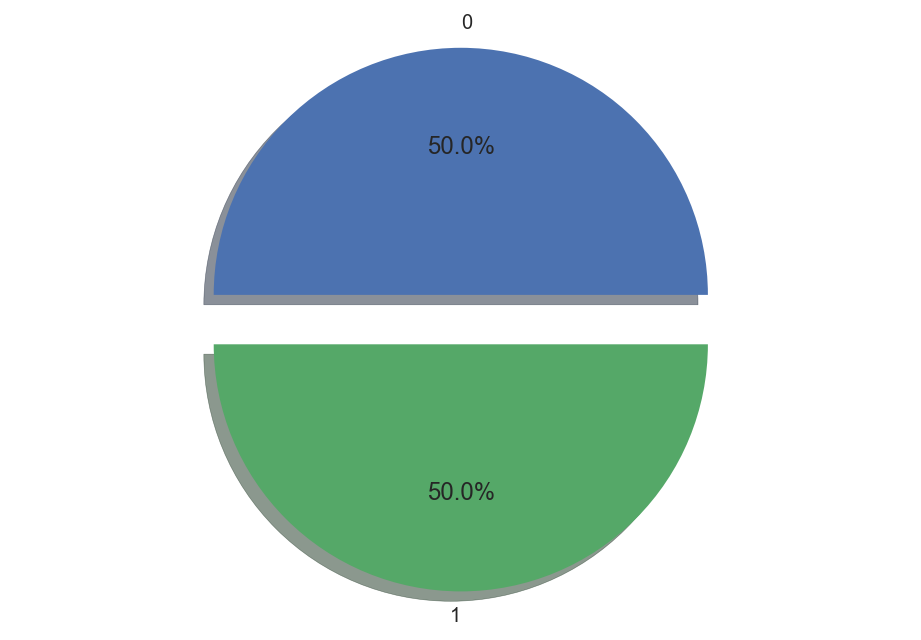

In [17]:
sm = SMOTE(random_state=0,n_jobs=-1)
X_train_res, y_train_res = sm.fit_sample(X_train, y_train)
print('Información del dataset aplicando el algoritmo Smote:'
      '\n y: {}'.format(Counter(y_train_res)))
plot_pie(y_train_res)

In [18]:
# Functions to restart the classifiers with the the best parameters selected for each model
def restart_classifiers():
    
    classifier_LR = LogisticRegression(C=10,warm_start=True,random_state=0,max_iter=300)
    classifier_RF = RandomForestClassifier(n_estimators=300,random_state=0,warm_start=True,criterion='gini',
                                           bootstrap=True,min_samples_leaf=156,max_features='sqrt',
                                           min_samples_split=156)
    classifier_linearSVC=LinearSVC(random_state=0,dual=True,penalty='l2',C=1,loss='squared_hinge')
    classifier_SVC = SVC(kernel='rbf',probability=True,max_iter=300,random_state=0,C=10)
    classifier_GB = GradientBoostingClassifier(random_state=0,subsample=0.8,n_estimators=300,presort=True,
                                               learning_rate=0.05,min_samples_leaf=156,max_features='sqrt',
                                               min_samples_split=156)
    algorithms=[classifier_LR,classifier_RF,classifier_linearSVC,classifier_SVC,classifier_GB]
    
    return algorithms

In [19]:
def train_classifier(X_train, y_train, X_test, models,scoring,probs=False):
    #create table to compare the metrics between each model
    compare_table_columns = [
    'Algorithm', 'Test average-precision','Test Accuracy Mean',
    'Test Accuracy 3*STD','Test F1','Test Recall','Parameters','Time']
    compare_table = pd.DataFrame(columns = compare_table_columns)
    #create table to compare predictions between each model
    compare_table_predict= {'real values': {'prediction':[list(y_train)]}}
    row_index = 0
    for alg in models:
        #set name and parameters
        table_name = alg.__class__.__name__
        compare_table.loc[row_index, 'Algorithm'] = table_name
        compare_table.loc[row_index, 'Parameters'] = str(alg.get_params())
        
        #score model with cross validation: http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_validate.html#sklearn.model_selection.cross_validate
        cv_results = cross_validate(estimator=alg,X=X_train,scoring=scores,y=y_train, 
                                    cv = 10,return_train_score=False)
        compare_table.loc[row_index, 'Time'] = cv_results['fit_time'].mean()
        compare_table.loc[row_index, 'Test average-precision'] = cv_results['test_average-precision'].mean()
        compare_table.loc[row_index, 'Test Accuracy Mean'] = cv_results['test_accuracy'].mean()   
        #if this is a non-bias random sample, then +/-3 standard deviations (std) from the mean, should statistically capture 99.7% of the subsets
        compare_table.loc[row_index, 'Test Accuracy 3*STD'] = cv_results['test_accuracy'].std()*3   #let's know the worst that can happen!
        compare_table.loc[row_index, 'Test Recall'] = cv_results['test_recall'].mean() 
        compare_table.loc[row_index, 'Test F1'] = cv_results['test_F1'].mean()
        #compare_table.loc[row_index, 'Test Roc-Auc Mean'] = cv_results['test_roc-auc-score'].mean()

        #save predictions
        alg.fit(X_train, y_train)
        compare_table_predict.update({table_name: {'prediction':alg.predict(X_test)} })
        
        row_index+=1
    
    return [compare_table,compare_table_predict]

In [20]:
scores={'accuracy': make_scorer(accuracy_score),
        'precision': make_scorer(precision_score),
        'recall':make_scorer(recall_score),
        'F1':make_scorer(f1_score),
        #'roc-auc-score':make_scorer(roc_auc_score),
        'average-precision':'average_precision'}

In [21]:
algorithms=restart_classifiers()
results, predictions=train_classifier(
    X_train=X_train,y_train=y_train,X_test=X_test,models=algorithms,scoring=scores)
results.sort_values(by = ['Test Accuracy Mean','Test F1'], ascending = False, inplace = True)
results

,Algorithm,Test average-precision,Test Accuracy Mean,Test Accuracy 3*STD,Test F1,Test Recall,Parameters,Time
4,GradientBoostingClassifier,0.626913,0.978191,0.0190153,0.345952,0.3,"{'criterion': 'friedman_mse', 'init': None, 'l...",0.537299
1,RandomForestClassifier,0.530375,0.975691,0.00544566,0,0,"{'bootstrap': True, 'class_weight': None, 'cri...",1.18059
2,LinearSVC,0.362626,0.975691,0.00544566,0,0,"{'C': 1, 'class_weight': None, 'dual': True, '...",0.00773244
3,SVC,0.527068,0.975691,0.00544566,0,0,"{'C': 10, 'cache_size': 200, 'class_weight': N...",0.0745285
0,LogisticRegression,0.404472,0.97507,0.00817873,0,0,"{'C': 10, 'class_weight': None, 'dual': False,...",0.0036447


In [22]:
algorithms=restart_classifiers()
results_res, predictions_res=train_classifier(
    X_train=X_train_res,y_train=y_train_res,X_test=X_test,models=algorithms,scoring=scores)
results_res.sort_values(by = ['Test Accuracy Mean','Test F1'], ascending = False, inplace = True)
results_res

,Algorithm,Test average-precision,Test Accuracy Mean,Test Accuracy 3*STD,Test F1,Test Recall,Parameters,Time
4,GradientBoostingClassifier,0.994741,0.982774,0.0319737,0.983029,0.995537,"{'criterion': 'friedman_mse', 'init': None, 'l...",1.17985
1,RandomForestClassifier,0.980975,0.93868,0.0436332,0.939013,0.943157,"{'bootstrap': True, 'class_weight': None, 'cri...",2.0784
2,LinearSVC,0.931894,0.89744,0.0412909,0.901602,0.938641,"{'C': 1, 'class_weight': None, 'dual': True, '...",0.02281
0,LogisticRegression,0.932086,0.896485,0.0359427,0.900071,0.931627,"{'C': 10, 'class_weight': None, 'dual': False,...",0.0112801
3,SVC,0.959337,0.895829,0.0578954,0.902137,0.958472,"{'C': 10, 'cache_size': 200, 'class_weight': N...",0.571124


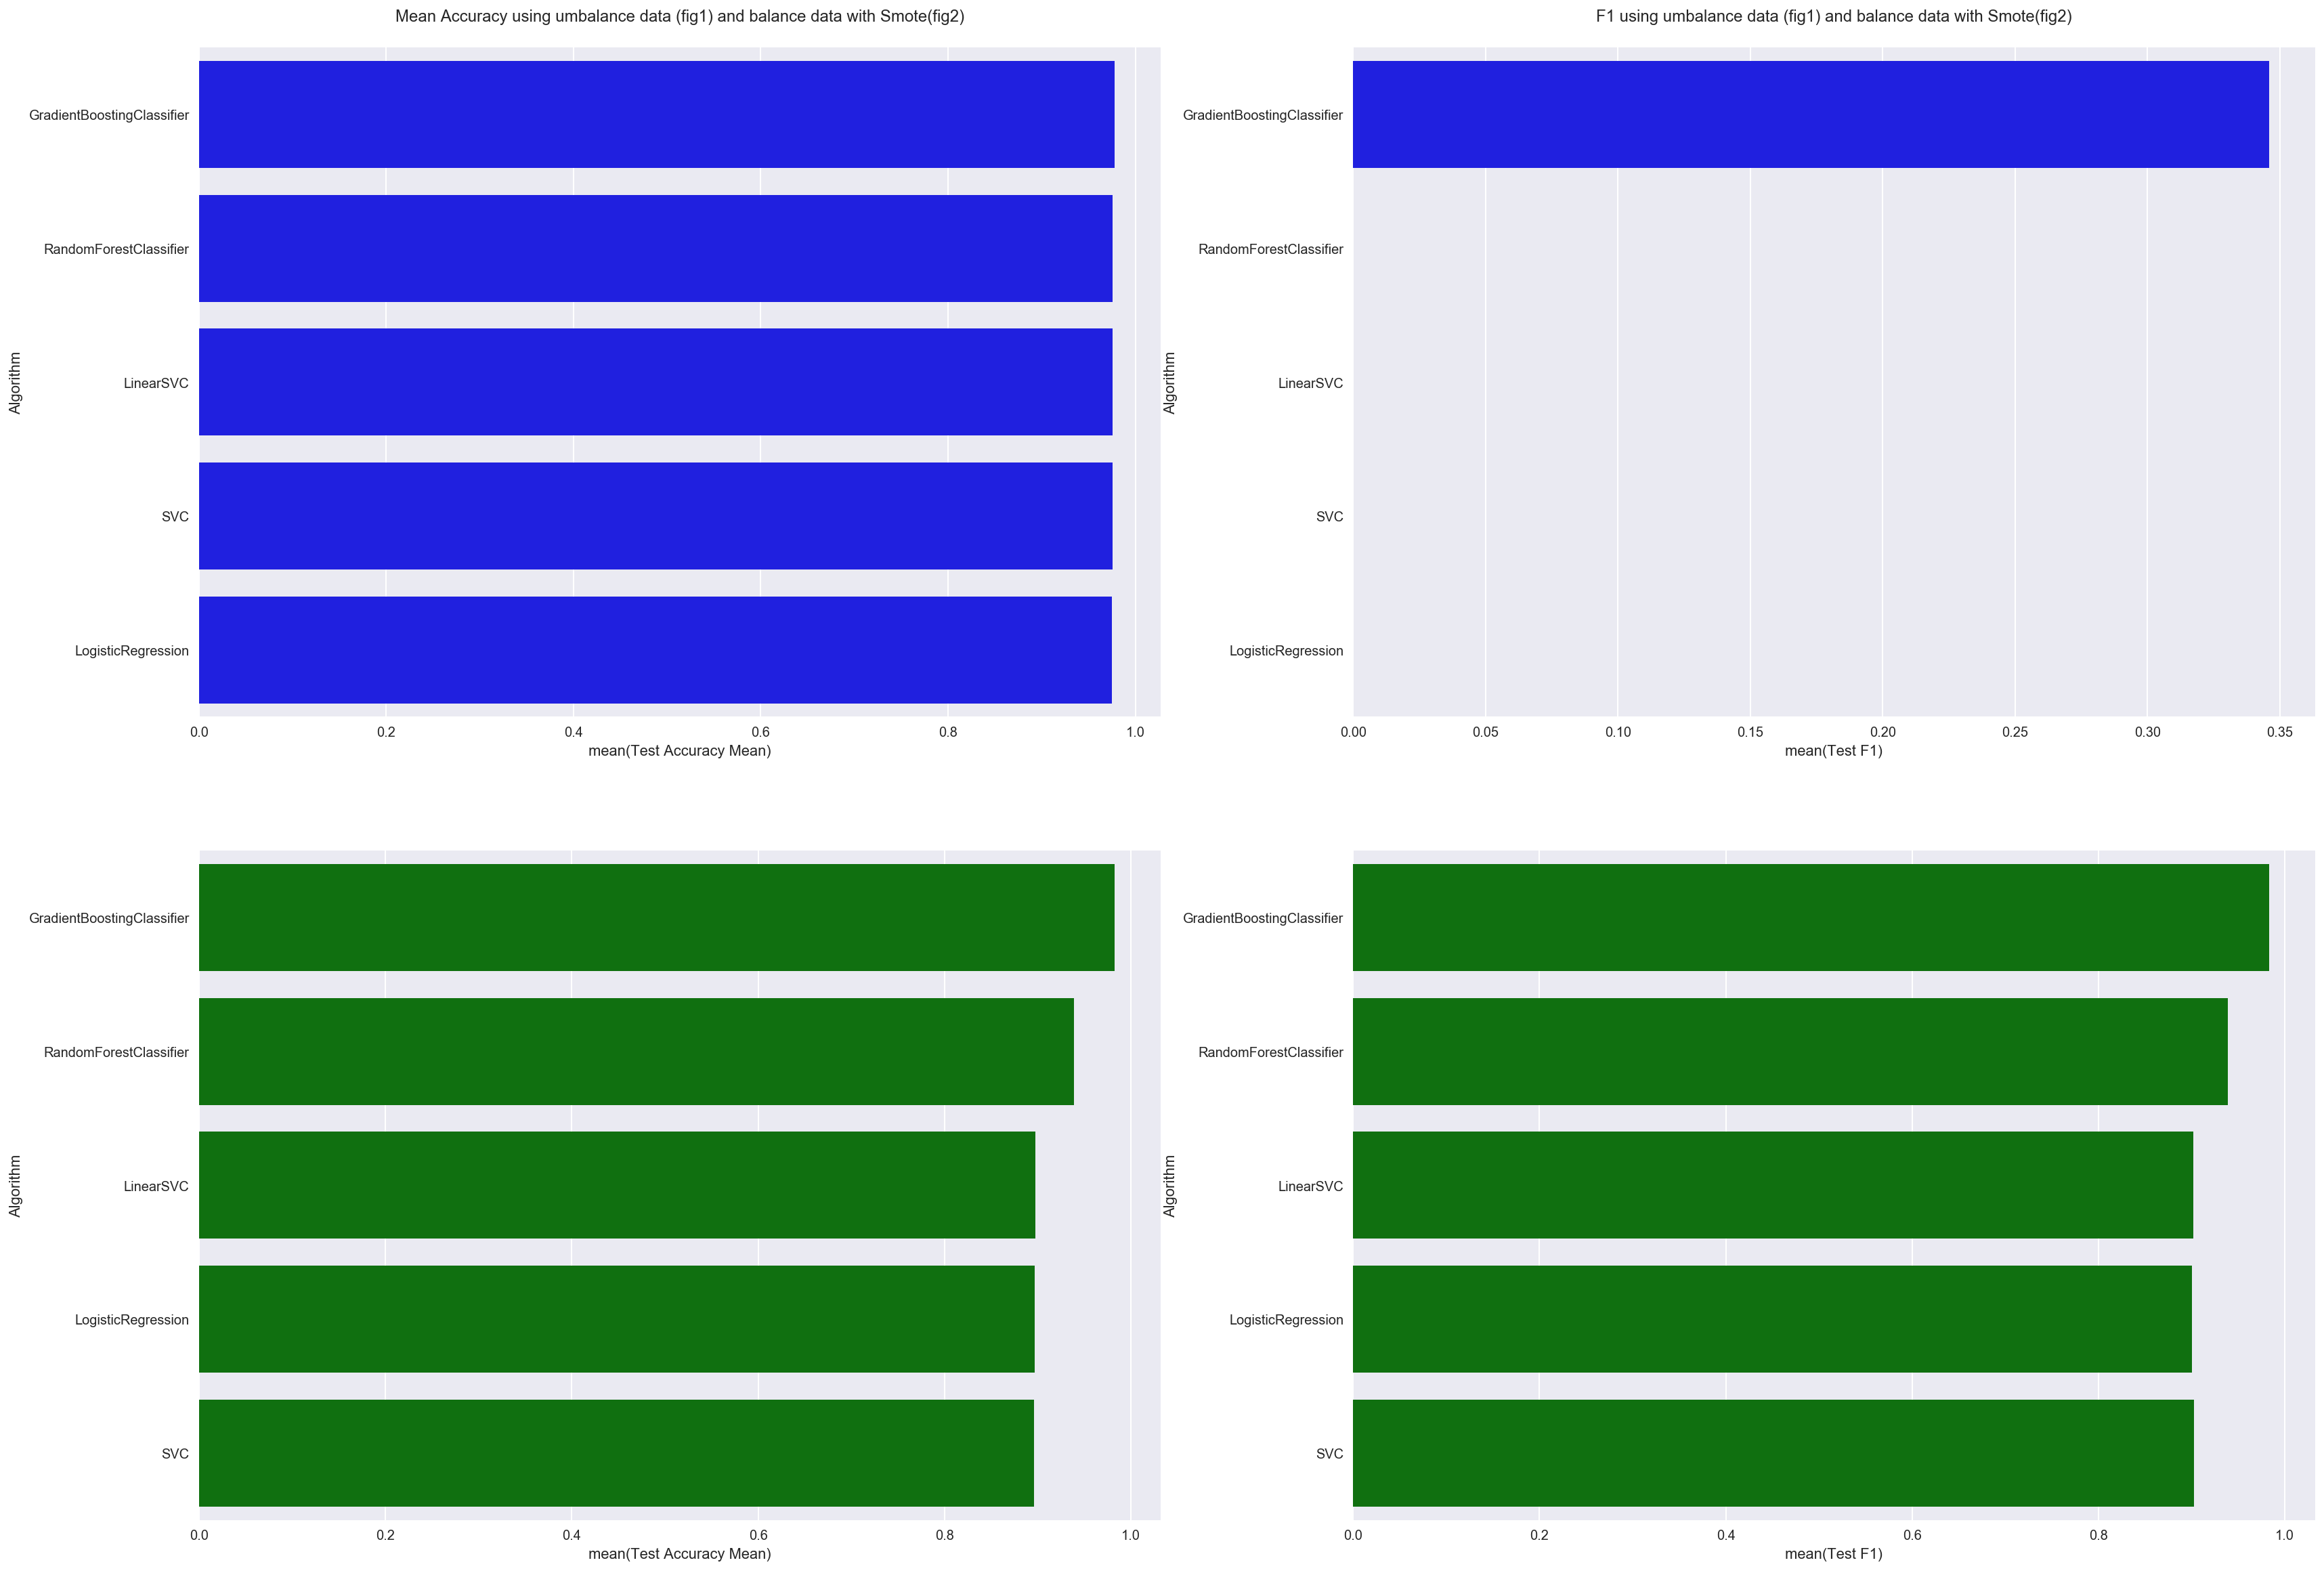

In [23]:
fig, axis = plt.subplots(2, 2,figsize=(28,20))
axis[0,0].set_title('Mean Accuracy using umbalance data (fig1) and balance data with Smote(fig2)\n')
sns.barplot(x='Test Accuracy Mean', y = 'Algorithm', data = results, color = 'b',ax = axis[0,0])
sns.barplot(x='Test F1', y = 'Algorithm', data = results, color = 'b',ax = axis[0,1])
axis[0,1].set_title('F1 using umbalance data (fig1) and balance data with Smote(fig2)\n')
sns.barplot(x='Test Accuracy Mean', y = 'Algorithm', data = results_res, color = 'g',ax = axis[1,0])
sns.barplot(x='Test F1', y = 'Algorithm', data = results_res, color = 'g',ax = axis[1,1]);

### Test del modelo

* En esta etapa se prueban las configuraciones seleccionadas que han obtenido la mejor performance contra el data de test que está sin balancear, las cuales son para este caso:

    * Datos de entrenamiento balanceados con Smote
    * Algoritmos de Gradient Boosting, Random Forest y Regresión logística


* Se calculan todas las métricas de clasificación, y se entrega un especial enfásis en las métricas de accuracy y roc-auc score, siempre cuidando el adecuado balance entre la precisión y el recall entre las clases

In [24]:
def test_classifier(X_train, y_train, X_test, y_test, classifier,probs=False):
    classifier_name = str(type(classifier).__name__)
    print("Testing " + classifier_name)
    now = time()
    list_of_labels = sorted(list(set(y_train)))
    model = classifier.fit(X_train, y_train)
    print("Learing time {0}s".format(time() - now))
    now = time()
    predictions = model.predict(X_test)
    print("Predicting values time {0}s".format(time() - now))
    if(probs):
        now = time()
        probs_prediction= model.predict_proba(X_test)
        print("Predicting probs time {0}s".format(time() - now))
        roc_auc   = roc_auc_score(y_test, probs_prediction[:,1])
    
    precision = precision_score(y_test, predictions, average=None, pos_label=None, labels=list_of_labels)
    recall    = recall_score(y_test, predictions, average=None, pos_label=None, labels=list_of_labels)
    accuracy  = accuracy_score(y_test, predictions)
    f1score   = f1_score(y_test, predictions, average=None, pos_label=None, labels=list_of_labels)
    cr        = classification_report(y_test, predictions)
    cm        = pd.crosstab(y_test, predictions, rownames=['Actual class'], colnames=['Predicted class'],margins=True)
    results   = {classifier_name: 
                 {
                     'F1':f1score,
                     'Precision':precision,
                     'Recall':recall,
                     'Accuracy':accuracy,
                 }
                }
    if(probs):
        results.update({classifier_name: {
            'F1':f1score,
            'Precision':precision,
            'Recall':recall,
            'Accuracy':accuracy,
            'Roc-Auc':roc_auc} })
        return [results,cr,cm, predictions, probs_prediction]
    else:
        return [results,cr,cm,predictions]

In [25]:
algorithms=restart_classifiers()
classifier_GB=algorithms[4]
classifier_RF=algorithms[1]
classifier_LR=algorithms[0]
selected_models=[classifier_GB,classifier_RF,classifier_LR]
results=[]
classif_report=[]
confusion_matrix=[]
preds=[]
probs_prediction=[]
for model in selected_models:
    aux,cr,cm,predictions, probs=test_classifier(
        X_train=X_train_res, y_train=y_train_res,X_test=X_test, 
        y_test=y_test,classifier=model,probs=True)
    results.append(aux)
    classif_report.append(cr)
    confusion_matrix.append(cm)
    preds.append(predictions)
    probs_prediction.append(probs)

Testing GradientBoostingClassifier
Learing time 1.1689660549163818s
Predicting values time 0.010977745056152344s
Predicting probs time 0.01128697395324707s
Testing RandomForestClassifier
Learing time 2.152272939682007s
Predicting values time 0.04773688316345215s
Predicting probs time 0.07512998580932617s
Testing LogisticRegression
Learing time 0.009546995162963867s
Predicting values time 0.0010597705841064453s
Predicting probs time 0.0008797645568847656s


In [26]:
print("Accuracy: {0}".format(results[0].get('GradientBoostingClassifier').get('Accuracy')))
print(classif_report[0])
confusion_matrix[0]

Accuracy: 0.9607558139534884
             precision    recall  f1-score   support

          0       0.98      0.98      0.98       657
          1       0.57      0.52      0.54        31

avg / total       0.96      0.96      0.96       688



Predicted class,0,1,All
Actual class,,,
0,645,12,657
1,15,16,31
All,660,28,688


In [27]:
print("Accuracy: {0}".format(results[1].get('RandomForestClassifier').get('Accuracy')))
print(classif_report[1])
confusion_matrix[1]

Accuracy: 0.9273255813953488
             precision    recall  f1-score   support

          0       0.99      0.94      0.96       657
          1       0.35      0.71      0.47        31

avg / total       0.96      0.93      0.94       688



Predicted class,0,1,All
Actual class,,,
0,616,41,657
1,9,22,31
All,625,63,688


In [28]:
print("Accuracy: {0}".format(results[2].get('LogisticRegression').get('Accuracy')))
print(classif_report[2])
confusion_matrix[2]

Accuracy: 0.8837209302325582
             precision    recall  f1-score   support

          0       0.99      0.89      0.94       657
          1       0.26      0.84      0.39        31

avg / total       0.96      0.88      0.91       688



Predicted class,0,1,All
Actual class,,,
0,582,75,657
1,5,26,31
All,587,101,688


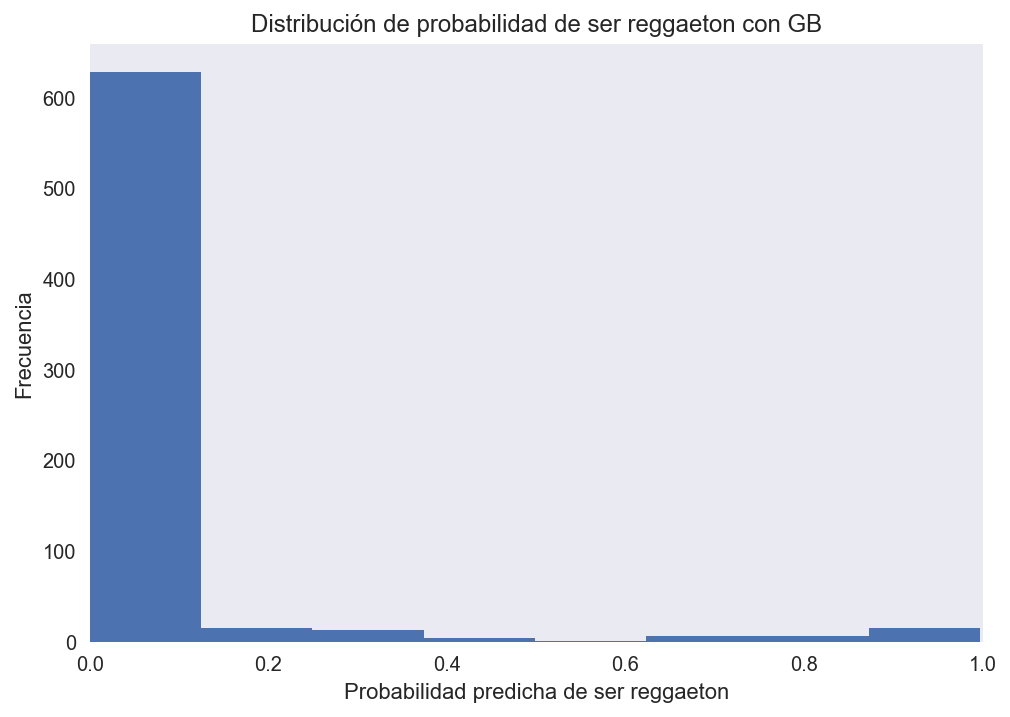

In [29]:
plt.hist(probs_prediction[0][:,1], bins=8)
plt.xlim(0, 1)
plt.title('Distribución de probabilidad de ser reggaeton con GB')
plt.xlabel('Probabilidad predicha de ser reggaeton')
plt.ylabel('Frecuencia')
plt.grid(False);

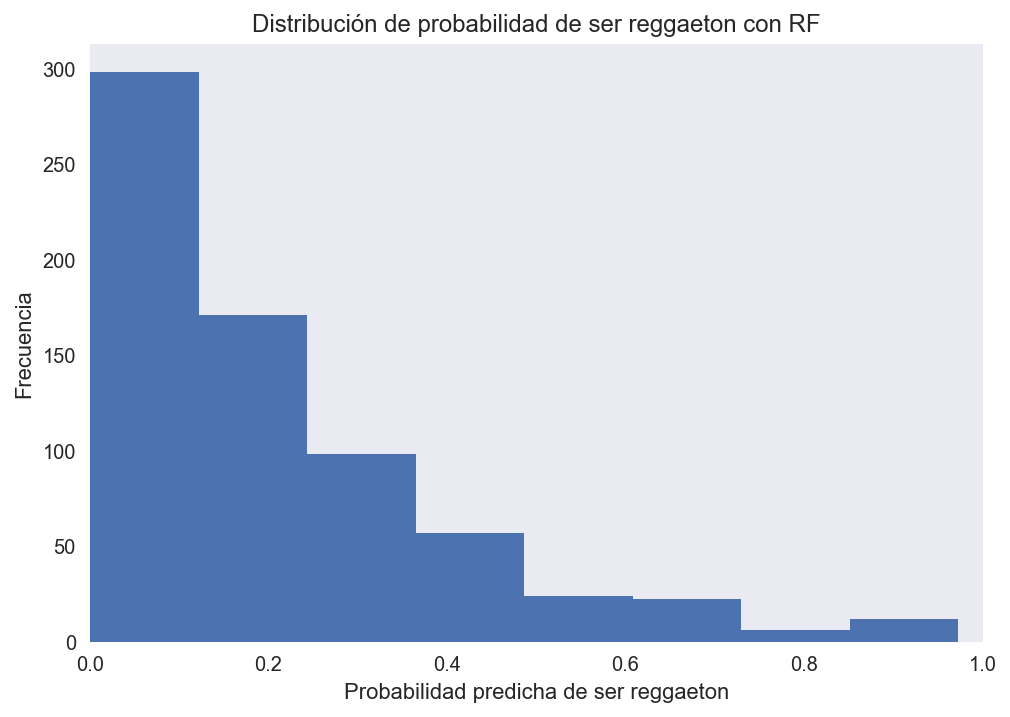

In [30]:
plt.hist(probs_prediction[1][:,1], bins=8)
plt.xlim(0, 1)
plt.title('Distribución de probabilidad de ser reggaeton con RF')
plt.xlabel('Probabilidad predicha de ser reggaeton')
plt.ylabel('Frecuencia')
plt.grid(False);

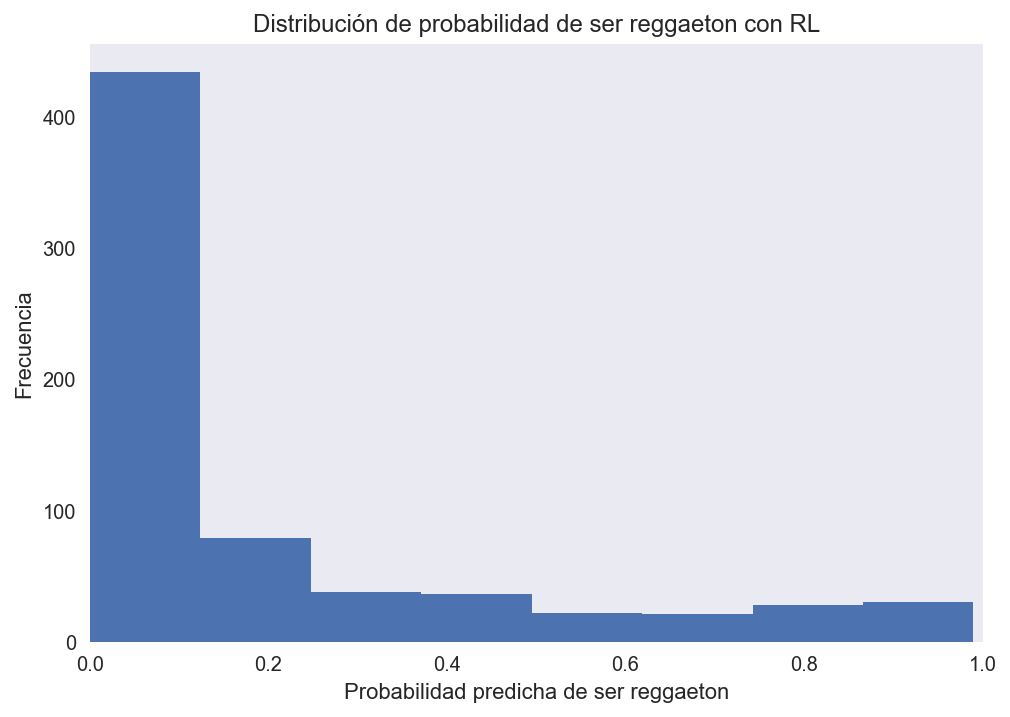

In [31]:
plt.hist(probs_prediction[2][:,1], bins=8)
plt.xlim(0, 1)
plt.title('Distribución de probabilidad de ser reggaeton con RL')
plt.xlabel('Probabilidad predicha de ser reggaeton')
plt.ylabel('Frecuencia')
plt.grid(False);

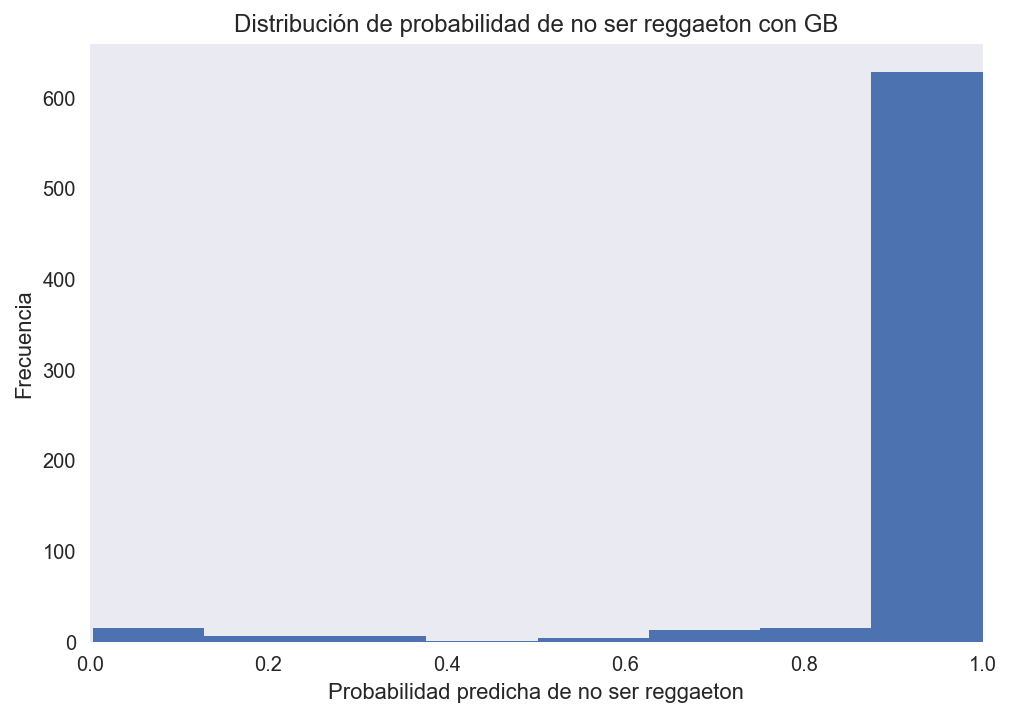

In [32]:
plt.hist(probs_prediction[0][:,0], bins=8)
plt.xlim(0, 1)
plt.title('Distribución de probabilidad de no ser reggaeton con GB')
plt.xlabel('Probabilidad predicha de no ser reggaeton')
plt.ylabel('Frecuencia')
plt.grid(False);

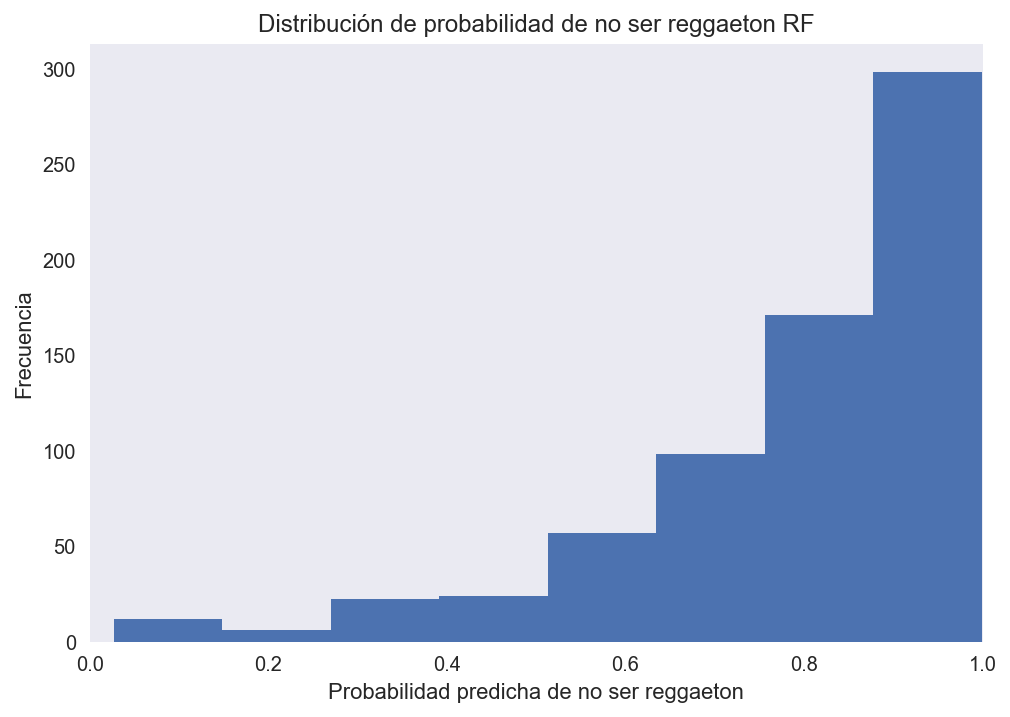

In [33]:
plt.hist(probs_prediction[1][:,0], bins=8)
plt.xlim(0, 1)
plt.title('Distribución de probabilidad de no ser reggaeton RF')
plt.xlabel('Probabilidad predicha de no ser reggaeton')
plt.ylabel('Frecuencia')
plt.grid(False);

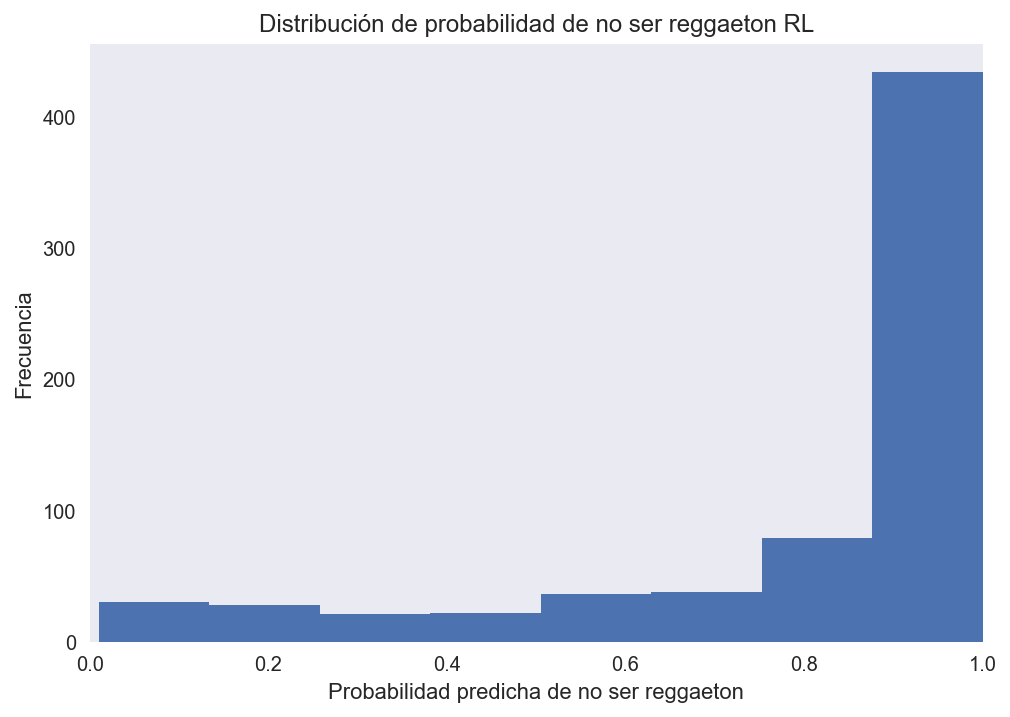

In [34]:
plt.hist(probs_prediction[2][:,0], bins=8)
plt.xlim(0, 1)
plt.title('Distribución de probabilidad de no ser reggaeton RL')
plt.xlabel('Probabilidad predicha de no ser reggaeton')
plt.ylabel('Frecuencia')
plt.grid(False);

0.955270781165611


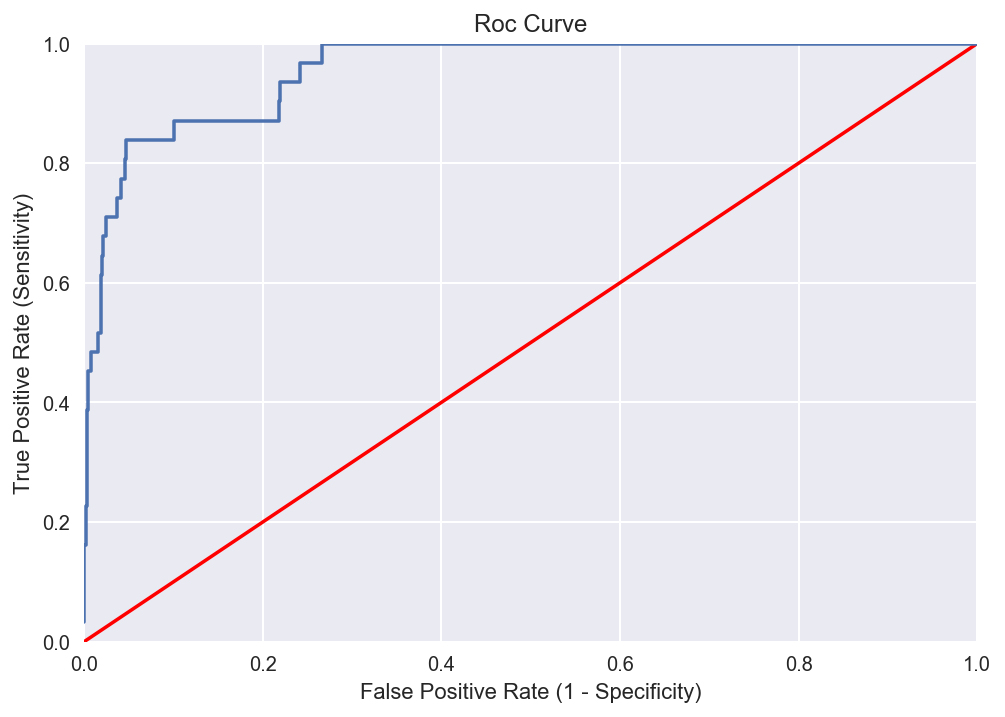

In [35]:
#Visualización de la curva ROC: equilibrio entre True (tpr) and False (fpr) Positive Rate
preds=binarize([probs_prediction[0][:,1]],0.5)[0]
print(results[0].get('GradientBoostingClassifier').get('Roc-Auc'))
line = np.linspace(0, 1, 2)
plt.plot(line, 'r')
fpr, tpr, thresholds = roc_curve(y_true=y_test, y_score=probs_prediction[0][:,1],pos_label=1)
plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.title('Roc Curve')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.grid(True);

0.9546324937398734


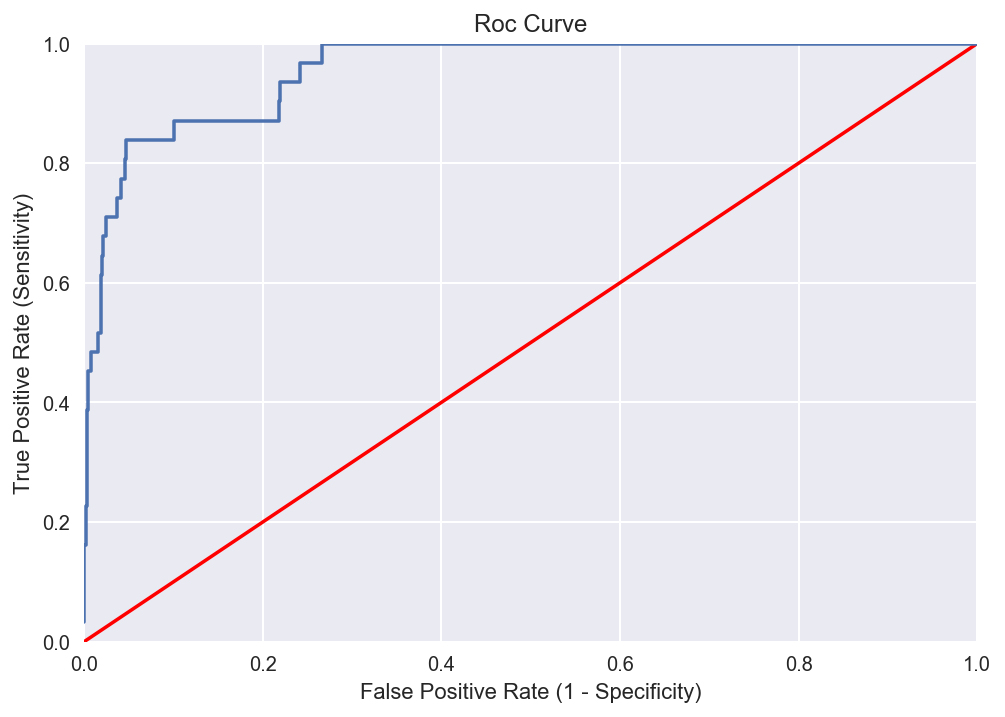

In [36]:
#Visualización de la curva ROC: equilibrio entre True (tpr) and False (fpr) Positive Rate
preds=binarize([probs_prediction[1][:,1]],0.5)[0]
print(results[1].get('RandomForestClassifier').get('Roc-Auc'))
line = np.linspace(0, 1, 2)
plt.plot(line, 'r')
fpr, tpr, thresholds = roc_curve(y_true=y_test, y_score=probs_prediction[0][:,1],pos_label=1)
plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.title('Roc Curve')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.grid(True);

0.9245838856974518


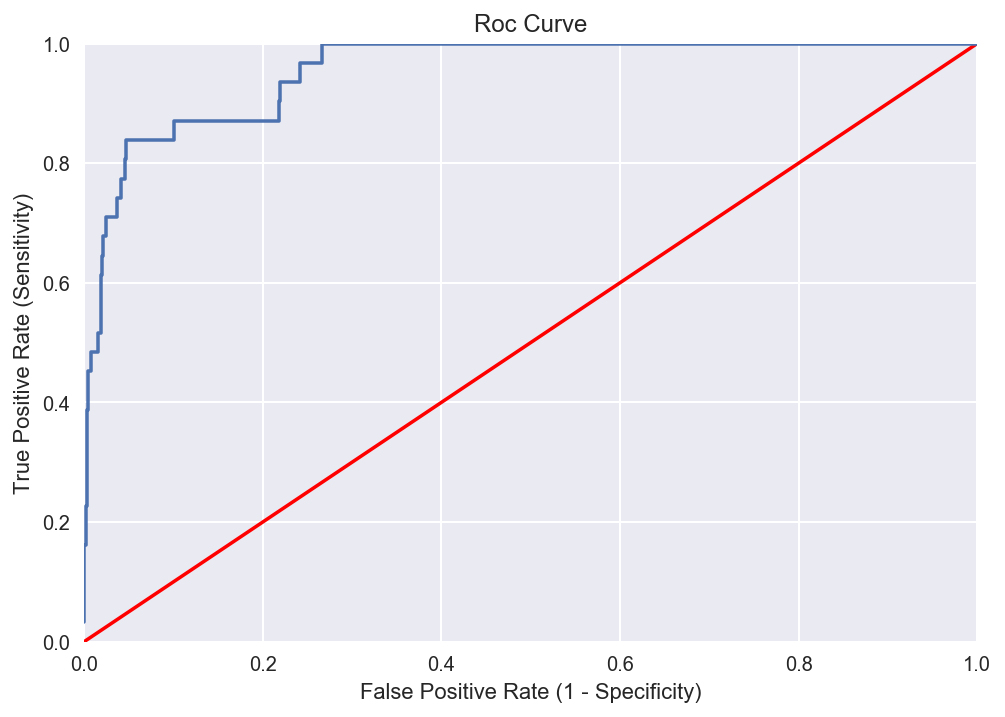

In [37]:
#Visualización de la curva ROC: equilibrio entre True (tpr) and False (fpr) Positive Rate
preds=binarize([probs_prediction[2][:,1]],0.5)[0]
print(results[2].get('LogisticRegression').get('Roc-Auc'))
line = np.linspace(0, 1, 2)
plt.plot(line, 'r')
fpr, tpr, thresholds = roc_curve(y_true=y_test, y_score=probs_prediction[0][:,1],pos_label=1)
plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.title('Roc Curve')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.grid(True);

### Validaciones adicionales y Conclusiones


**Validación adicional**

* Dado que la cantidad de datos de la clase positiva era muy baja como para dejar una muestra adicional para validar, hemos decidido hacer la siguiente validación:

    * Se grafica un histograma que muestra la distribución de probabilidad predicha para aquellas variables del data de test que si son reggaeton y las que no por separado. Lo esperable, es que mientras mejor sea el modelo, mayor cantidad de datos por arriba de una probabilidad de 0.5 debería haber en las que si y vicebersa en el contrario.
    
** Conclusiones de la 1era iteración y siguientes pasos para la 2da**

* Nos quedamos inicialmente con el modelo de GB como principal candidatos a ser elegido, pues es el que tuvo menos variabilidad en la precisión durante el entrenamiento, sus resultados de entrenamiento y test son similares (indicio de que no hay sobre ajuste significativo) e identifica muy bien los que no son reggaeton,y es el que identifica con mejor precisión a los que si son reggaeton.


* Podemos notar que el orden de importancia de las variables es el mismo, independiente del algoritmo utilizado


* El paso siguiente en la 2da iteración será aplicar una optimización de parámetros con Gridsearch a solo estos 3 modelos con la configuración de datos balanceada con el algoritmo Smote

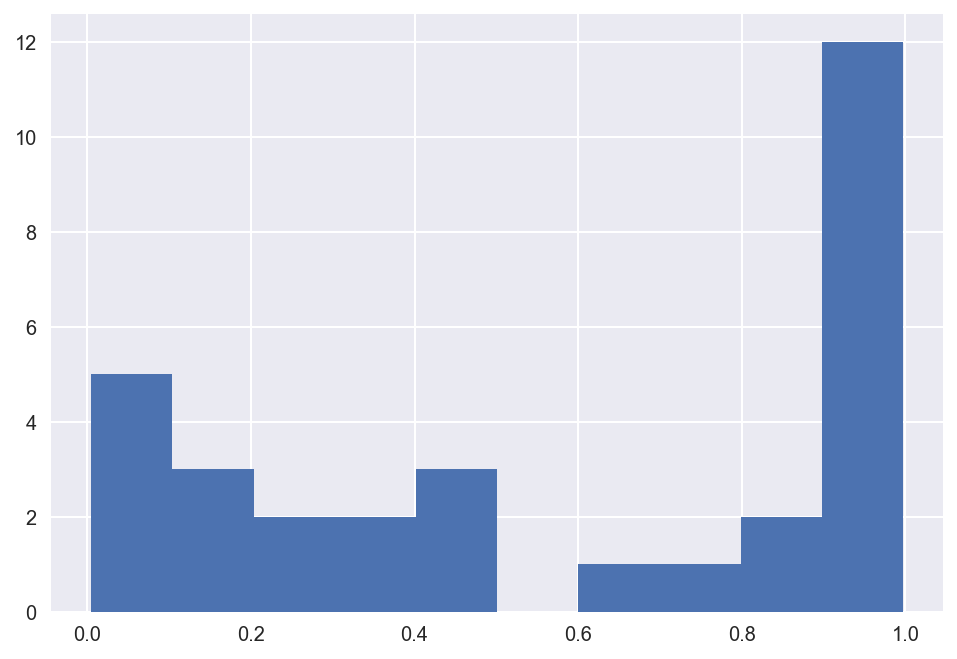

In [38]:
X_test['prob_reggaeton']=probs_prediction[0][:,1]
X_test['reggaeton']=y_test
X_test[(X_test.reggaeton==1)].loc[:,'prob_reggaeton'].hist();

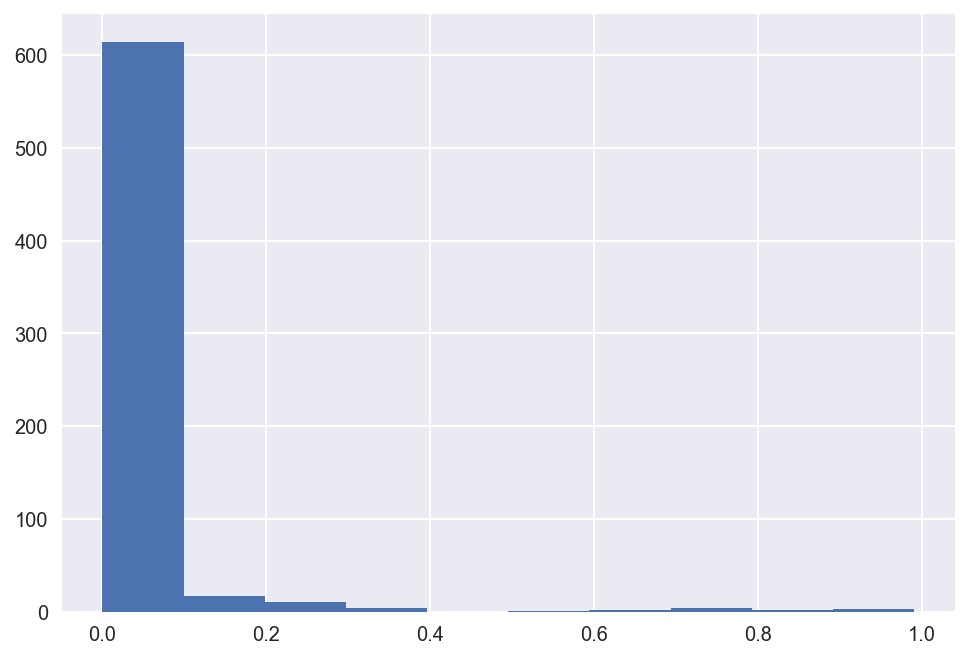

In [39]:
X_test[(X_test.reggaeton==0)].loc[:,'prob_reggaeton'].hist();
del X_test['prob_reggaeton']
del X_test['reggaeton']

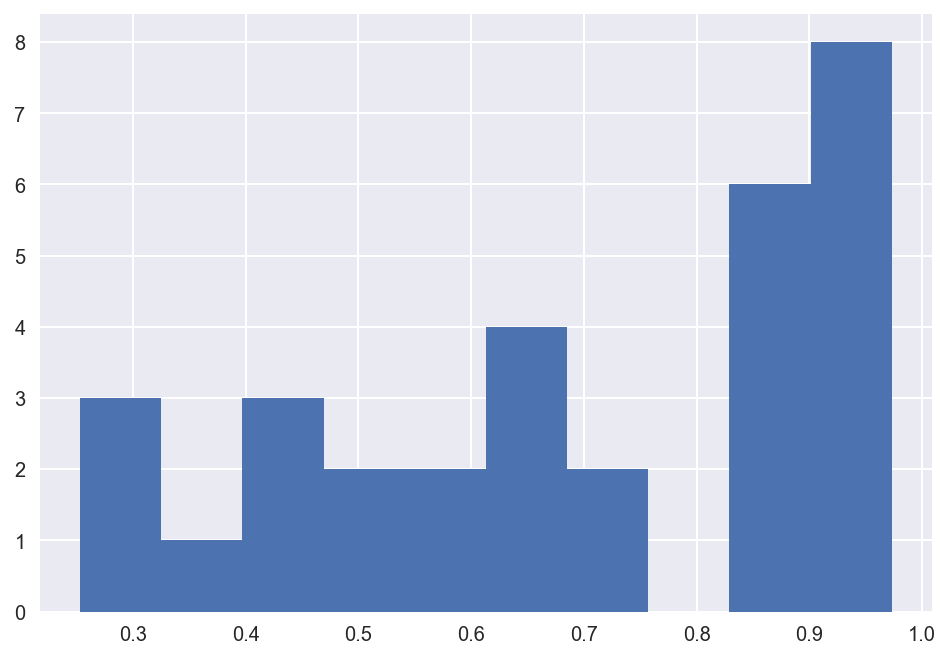

In [40]:
X_test['prob_reggaeton']=probs_prediction[1][:,1]
X_test['reggaeton']=y_test
X_test[(X_test.reggaeton==1)].loc[:,'prob_reggaeton'].hist();

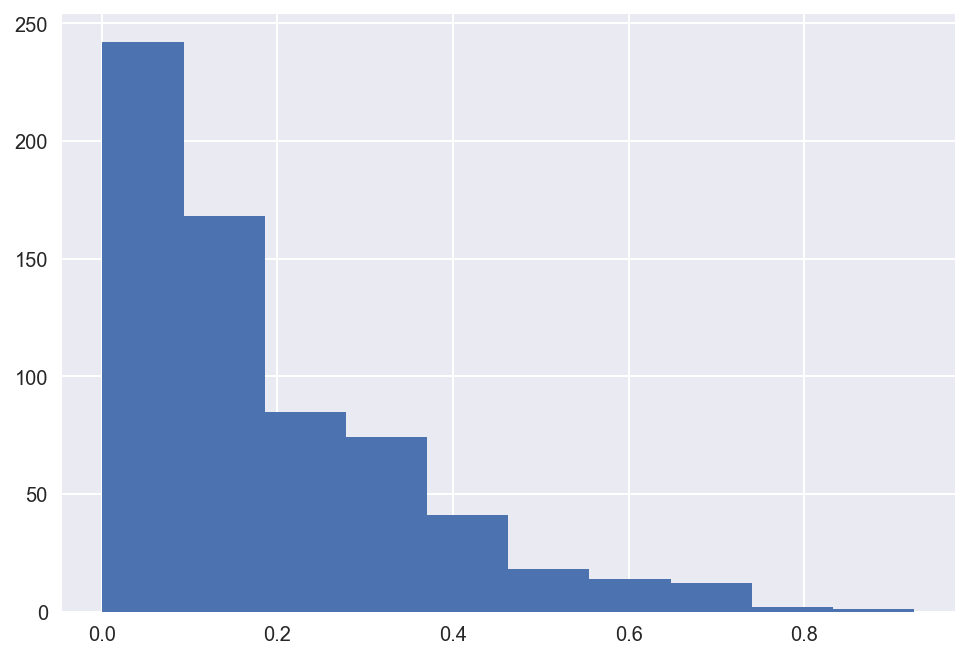

In [41]:
X_test[(X_test.reggaeton==0)].loc[:,'prob_reggaeton'].hist();
del X_test['prob_reggaeton']
del X_test['reggaeton']

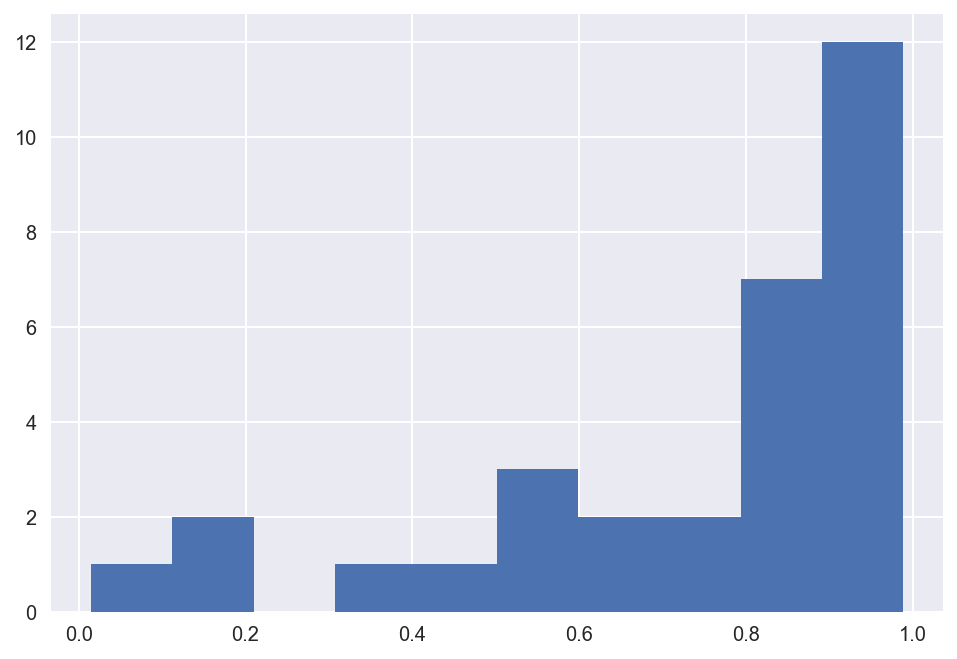

In [42]:
X_test['prob_reggaeton']=probs_prediction[2][:,1]
X_test['reggaeton']=y_test
X_test[(X_test.reggaeton==1)].loc[:,'prob_reggaeton'].hist();

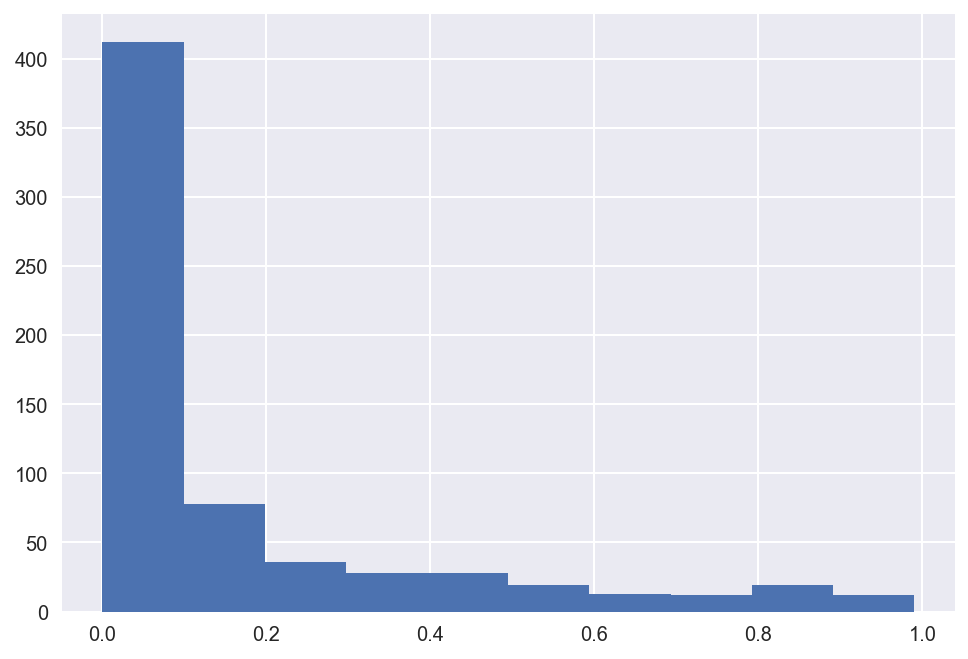

In [43]:
X_test[(X_test.reggaeton==0)].loc[:,'prob_reggaeton'].hist();
del X_test['prob_reggaeton']
del X_test['reggaeton']

In [44]:
data={'names':X_train.columns.values,'coef':np.abs(classifier_GB.feature_importances_)}
aux=pd.DataFrame(data=data,columns=['names','coef'])
aux.sort_values(by='coef',ascending=False)

,names,coef
5,tempo_scale,0.193802
0,danceability,0.187072
3,acousticness,0.177247
1,energy,0.160623
2,speechiness,0.142336
4,valence,0.138921


In [45]:
data={'names':X_train.columns.values,'coef':np.abs(classifier_RF.feature_importances_)}
aux=pd.DataFrame(data=data,columns=['names','coef'])
aux.sort_values(by='coef',ascending=False)

,names,coef
0,danceability,0.373905
2,speechiness,0.206054
1,energy,0.174390
5,tempo_scale,0.136795
3,acousticness,0.081971
4,valence,0.026884


In [46]:
data={'names':X_train.columns.values,'coef':np.abs(classifier_LR.coef_[0])}
aux=pd.DataFrame(data=data,columns=['names','coef'])
aux.sort_values(by='coef',ascending=False)

,names,coef
0,danceability,14.557842
2,speechiness,14.481787
5,tempo_scale,7.575888
1,energy,6.373414
3,acousticness,4.297037
4,valence,0.208216
